Uses tensorforce tensorforce-0.3.0

Took 8 million steps over about a day to warm up. Got 1.6e-4 which is about 25% a month, 25x a year.


In [1]:
# plotting
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# numeric
import numpy as np
from numpy import random
import pandas as pd
import tensorflow as tf

# util
from collections import Counter
import pdb
import glob
import time
import tempfile
import itertools
from tqdm import tqdm_notebook as tqdm
import datetime

# logging
import logging
logger = log = logging.getLogger(__name__)
# log.setLevel(logging.INFO)
logging.basicConfig()
log.info('%s logger started.', __name__)

In [2]:
import gym
from gym import error, spaces, utils
from gym.utils import seeding

In [3]:
import os
os.sys.path.append(os.path.abspath('.'))
%reload_ext autoreload
%autoreload 2

In [4]:
# params
window_length = 50
cash_bias = 0.0
batch_size=128
import datetime
ts = datetime.datetime.utcnow().strftime('%Y%m%d_%H-%M-%S')
save_path = './outputs/tensorforce-PPO/tensorforce_PPO_crypto-%s' % ts
# save_path = './outputs/tensorforce-PPO/tensorforce_PPO_crypto_20171105_06-50-31'
save_path

'./outputs/tensorforce-PPO/tensorforce_PPO_crypto-20180123_04-18-18'

In [5]:
log_dir = os.path.join('logs', os.path.splitext(os.path.basename(save_path))[0], 'run-' + ts)
try:
    os.makedirs(log_dir)
except OSError:
    pass
log_dir

'logs/tensorforce_PPO_crypto-20180123_04-18-18/run-20180123_04-18-18'

# Enviroment

We will wrap out environment so we can modify the inputs, outputs, and attributes for tensorforce.

- tensorforce doesn't like dual outputs so we will concat them
- we need to softmax the weights since tensorforce doesn't do this

In [6]:
from rl_portfolio_management.environments.portfolio import PortfolioEnv
from rl_portfolio_management.wrappers import SoftmaxActions, ConcatStates

In [22]:
# tensorforce need us to use this wrapper, passing in a registered gym id
# this lets us pass in an object instead of registering it
from tensorforce.contrib.openai_gym import OpenAIGym
class TFOpenAIGymCust(OpenAIGym):
    def __init__(self, gym_id, gym):
        self.gym_id = gym_id
        self.gym = gym
        self.visualize = False

In [23]:
df_train = pd.read_hdf('./data/poloniex_30m.hf',key='train')
env = PortfolioEnv(
    df=df_train,
    steps=40, 
    scale=True, 
    trading_cost=0.0025, 
    window_length = window_length,
    output_mode='EIIE',
#     random_reset=False,
)
# wrap it in a few wrappers
env = ConcatStates(env)
env = SoftmaxActions(env)
environment = TFOpenAIGymCust('CryptoPortfolioEIIE-v0', env)

env.seed(0)

[0]

In [24]:
# sanity check out environment is working
state = environment.reset()
state, reward, done=environment.execute(env.action_space.sample())
state.shape

(3, 51, 4)

In [10]:
# sanity check out environment is working
state = env.reset()
state, reward, done, info=env.step(env.action_space.sample())
state.shape

(3, 51, 4)

# Model

Derived from  https://github.com/reinforceio/tensorforce/blob/0d07fadec03f76537a2431e17c51cd759d53b5e9/tensorforce/core/networks/layers.py#L90

Implemented as per CNN version of https://arxiv.org/abs/1706.10059 

In [11]:
# from tensorforce import Configuration
from tensorforce.agents import PPOAgent
from tensorforce.core.networks import LayeredNetwork, layers, Network, network

In [12]:
from tensorforce.core.networks import Layer, Conv2d, Nonlinearity
class EIIE(Layer):
    """
    EIIE layer
    """

    def __init__(self,
                 size=20,
                 bias=True,
                 activation='relu',
                 l2_regularization=0.0,
                 l1_regularization=0.0,
                 scope='EIIE',
                 summary_labels=()):
        self.size = size
        # Expectation is broadcast back over advantage values so output is of size 1
        self.conv1 = Conv2d(
            size=3,
            bias=bias,
            stride=(1,1),
            window=(1,3),
            padding='VALID',
            l2_regularization=l2_regularization,
            l1_regularization=l1_regularization,
            summary_labels=summary_labels)
        self.conv2 = Conv2d(
            size=size,
            bias=bias,
            stride=(1,window_length-2-1),
            window=(1,window_length-2-1),
            padding='VALID',
            l2_regularization=l2_regularization,
            l1_regularization=l1_regularization,
            summary_labels=summary_labels)
        self.conv3 = Conv2d(
            size=1,
            bias=bias,
            stride=(1,1),
            window=(1,1),
            l2_regularization=l2_regularization,
            l1_regularization=l1_regularization,
            summary_labels=summary_labels)
        self.nonlinearity = Nonlinearity(
            name=activation, summary_labels=summary_labels)
        self.nonlinearity2 = Nonlinearity(
            name=activation, summary_labels=summary_labels)
        super(EIIE, self).__init__(
            scope=scope, summary_labels=summary_labels)

    def tf_apply(self, x0, update):
        # where window_size=50, actions=4 (giving the 3), data cols=5
        # x0 = (None,3,50,5)
        # x = (None,3,49,5)
        # x = (None,3,1,1)
        # conv1 => (None,3, 47,3)
        # conv2 => (None,3, 1, 20)
        # concat=> (None,3, 1, 21)
        # conv3 => (None,3, 1, 1)
        # concat=> (None,2, 1, 1)

        w0 = x0[:,:,:1,:1]
        x = x0[:,:,1:,:]
        
        x = self.conv1.apply(x, update=update)
        x = self.nonlinearity.apply(x=x, update=update)
        
        x = self.conv2.apply(x, update=update)
        x = self.nonlinearity2.apply(x=x, update=update)
        
        x = tf.concat([x, w0], 3)
        x = self.conv3.apply(x, update=update)
        
        # concat on cash_bias
        cash_bias_int = 0
        # FIXME not sure how to make shape with a flexible size in tensorflow but this works for now
        # cash_bias = tf.ones(shape=(batch_size,1,1,1)) * cash_bias_int
        cash_bias = x[:,:1,:1,:1]*0 
        x = tf.concat([cash_bias, x], 1)

        if 'activations' in self.summary_labels:
            summary = tf.summary.histogram(name='activations', values=x)
            self.summaries.append(summary)

        return x

    def tf_regularization_loss(self):
        if super(EIIE, self).tf_regularization_loss() is None:
            losses = list()
        else:
            losses = [super(EIIE, self).tf_regularization_loss()]

        if self.conv1.regularization_loss() is not None:
            losses.append(self.conv1.regularization_loss())
        if self.conv2.regularization_loss() is not None:
            losses.append(self.conv2.regularization_loss())
        if self.conv1.regularization_loss() is not None:
            losses.append(self.conv3.regularization_loss())

        if len(losses) > 0:
            return tf.add_n(inputs=losses)
        else:
            return None

    def get_variables(self, include_non_trainable=False):
        layer_variables = super(EIIE, self).get_variables(
            include_non_trainable=include_non_trainable)

        layer_variables += self.conv1.get_variables(
            include_non_trainable=include_non_trainable)
        layer_variables += self.conv2.get_variables(
            include_non_trainable=include_non_trainable)
        layer_variables += self.conv3.get_variables(
            include_non_trainable=include_non_trainable)

        layer_variables += self.nonlinearity.get_variables(
            include_non_trainable=include_non_trainable)
        layer_variables += self.nonlinearity.get_variables(
            include_non_trainable=include_non_trainable)

        return layer_variables
    
# Add our custom layer
layers['EIIE'] = EIIE

# Network as list of layers
network_spec = [
    dict(type='EIIE', 
        l1_regularization=1e-8,
        l2_regularization=1e-8),
    dict(type='flatten')
]

In [13]:
# also add a custom baseline
from tensorforce.core.baselines import NetworkBaseline
from tensorforce.core.baselines import baselines


class EIIEBaseline(NetworkBaseline):
    """
    CNN baseline (single-state) consisting of convolutional layers followed by dense layers.
    """

    def __init__(self, layers_spec, scope='eiie-baseline', summary_labels=()):
        """
        CNN baseline.
        Args:
            conv_sizes: List of convolutional layer sizes
            dense_sizes: List of dense layer sizes
        """

        super(EIIEBaseline, self).__init__(layers_spec, scope, summary_labels)
        
# Add our custom baseline
baselines['EIIE']=EIIEBaseline

# Agent


In [16]:
explorations_spec=dict(
    type="epsilon_anneal",
    initial_epsilon=1.0,
    final_epsilon= 0.005,
    timesteps= int(1e5),
    start_timestep=0,
)

# I want to use a gaussian dist instead of beta, we will apply post processing to scale everything
# actions_spec = environment.actions.copy()
# del actions_spec["min_value"]
# del actions_spec["max_value"]
# distributions_spec=dict(action=dict(type='gaussian', mean=0.25, log_stddev=np.log(5e-2)))

# Or just use beta:
actions_spec = environment.actions.copy()
distributions_spec=None

# https://github.com/reinforceio/tensorforce/blob/d823809df746c61471e2cba5832ab051581baf7e/docs/summary_spec.md
summary_spec = dict(directory=log_dir, 
                        steps=50,
                        labels=[
                            'configuration',
                            'gradients_scalar',
                            'regularization',
                            'inputs',
                            'losses',
#                             'variables'
                        ]
                    )
agent = PPOAgent(
    states_spec=environment.states,
    actions_spec=actions_spec,
    network_spec=network_spec,
    batch_size=4096,
    saver_spec = dict(
        directory=save_path, 
        steps=100000, 
#         basename=os.path.basename(save_path)
    ),
    # Agent
    states_preprocessing_spec=None,
    explorations_spec=explorations_spec,
    reward_preprocessing_spec=None,
    # BatchAgent
    keep_last_timestep=True,
    # PPOAgent
    step_optimizer=dict(
        type='adam',
        learning_rate=1e-3
    ),
    optimization_steps=10,
    # Model
    scope='ppo',
    discount=0.99,
    # DistributionModel
    distributions_spec=distributions_spec,
    entropy_regularization=0.01, # 0 and 0.01 in baselines
    # PGModel
    baseline_mode='states',
    baseline=dict(
        type="EIIE",
        layers_spec=network_spec
#         update_batch_size=512,
    ), # string indicating the baseline value function (currently 'linear' or 'mlp').
    baseline_optimizer=dict(type='adam', learning_rate=0.003),
    gae_lambda=0.97,
    # PGLRModel
    likelihood_ratio_clipping=0.2,
    summary_spec=summary_spec,
    distributed_spec=None
)

INFO:tensorflow:Summary name gradients/ppo/optimization/moments/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments/Squeeze_1_0/mean instead.
[2018-01-23 12:19:30,287] Summary name gradients/ppo/optimization/moments/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments/Squeeze_1_0/variance instead.
[2018-01-23 12:19:30,296] Summary name gradients/ppo/optimization/moments/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_1/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_1/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_1/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_1/Squeeze_1_0/mean instead.
[2018-01-23 12:19:30,307] Summary name gradients/ppo/optimization/moments_1/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_1/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_1/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_1/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_1/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_1/Squeeze_1_0/variance instead.
[2018-01-23 12:19:30,315] Summary name gradients/ppo/optimization/moments_1/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_1/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_2/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_2/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_2/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_2/Squeeze_1_0/mean instead.
[2018-01-23 12:19:30,326] Summary name gradients/ppo/optimization/moments_2/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_2/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_2/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_2/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_2/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_2/Squeeze_1_0/variance instead.
[2018-01-23 12:19:30,333] Summary name gradients/ppo/optimization/moments_2/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_2/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_3/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_3/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_3/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_3/Squeeze_1_0/mean instead.
[2018-01-23 12:19:30,345] Summary name gradients/ppo/optimization/moments_3/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_3/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_3/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_3/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_3/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_3/Squeeze_1_0/variance instead.
[2018-01-23 12:19:30,351] Summary name gradients/ppo/optimization/moments_3/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_3/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_4/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_4/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_4/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_4/Squeeze_1_0/mean instead.
[2018-01-23 12:19:30,372] Summary name gradients/ppo/optimization/moments_4/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_4/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_4/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_4/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_4/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_4/Squeeze_1_0/variance instead.
[2018-01-23 12:19:30,384] Summary name gradients/ppo/optimization/moments_4/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_4/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_5/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_5/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_5/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_5/Squeeze_1_0/mean instead.
[2018-01-23 12:19:30,404] Summary name gradients/ppo/optimization/moments_5/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_5/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_5/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_5/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_5/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_5/Squeeze_1_0/variance instead.
[2018-01-23 12:19:30,410] Summary name gradients/ppo/optimization/moments_5/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_5/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_6/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_6/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_6/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_6/Squeeze_1_0/mean instead.
[2018-01-23 12:19:30,429] Summary name gradients/ppo/optimization/moments_6/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_6/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_6/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_6/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_6/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_6/Squeeze_1_0/variance instead.
[2018-01-23 12:19:30,434] Summary name gradients/ppo/optimization/moments_6/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_6/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_7/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_7/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_7/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_7/Squeeze_1_0/mean instead.
[2018-01-23 12:19:30,464] Summary name gradients/ppo/optimization/moments_7/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_7/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_7/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_7/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_7/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_7/Squeeze_1_0/variance instead.
[2018-01-23 12:19:30,473] Summary name gradients/ppo/optimization/moments_7/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_7/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_8/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_8/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_8/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_8/Squeeze_1_0/mean instead.
[2018-01-23 12:19:30,482] Summary name gradients/ppo/optimization/moments_8/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_8/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_8/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_8/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_8/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_8/Squeeze_1_0/variance instead.
[2018-01-23 12:19:30,486] Summary name gradients/ppo/optimization/moments_8/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_8/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_9/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_9/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_9/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_9/Squeeze_1_0/mean instead.
[2018-01-23 12:19:30,501] Summary name gradients/ppo/optimization/moments_9/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_9/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_9/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_9/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_9/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_9/Squeeze_1_0/variance instead.
[2018-01-23 12:19:30,504] Summary name gradients/ppo/optimization/moments_9/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_9/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_10/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_10/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_10/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_10/Squeeze_1_0/mean instead.
[2018-01-23 12:19:30,521] Summary name gradients/ppo/optimization/moments_10/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_10/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_10/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_10/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_10/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_10/Squeeze_1_0/variance instead.
[2018-01-23 12:19:30,524] Summary name gradients/ppo/optimization/moments_10/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_10/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_11/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_11/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_11/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_11/Squeeze_1_0/mean instead.
[2018-01-23 12:19:30,542] Summary name gradients/ppo/optimization/moments_11/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_11/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_11/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_11/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_11/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_11/Squeeze_1_0/variance instead.
[2018-01-23 12:19:30,545] Summary name gradients/ppo/optimization/moments_11/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_11/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_12/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_12/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_12/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_12/Squeeze_1_0/mean instead.
[2018-01-23 12:19:30,554] Summary name gradients/ppo/optimization/moments_12/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_12/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_12/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_12/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_12/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_12/Squeeze_1_0/variance instead.
[2018-01-23 12:19:30,557] Summary name gradients/ppo/optimization/moments_12/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_12/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_13/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_13/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_13/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_13/Squeeze_1_0/mean instead.
[2018-01-23 12:19:30,566] Summary name gradients/ppo/optimization/moments_13/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_13/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_13/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_13/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_13/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_13/Squeeze_1_0/variance instead.
[2018-01-23 12:19:30,569] Summary name gradients/ppo/optimization/moments_13/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_13/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_14/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_14/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_14/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_14/Squeeze_1_0/mean instead.
[2018-01-23 12:19:30,577] Summary name gradients/ppo/optimization/moments_14/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_14/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_14/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_14/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_14/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_14/Squeeze_1_0/variance instead.
[2018-01-23 12:19:30,588] Summary name gradients/ppo/optimization/moments_14/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_14/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_15/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_15/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_15/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_15/Squeeze_1_0/mean instead.
[2018-01-23 12:19:30,601] Summary name gradients/ppo/optimization/moments_15/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_15/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_15/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_15/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_15/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_15/Squeeze_1_0/variance instead.
[2018-01-23 12:19:30,606] Summary name gradients/ppo/optimization/moments_15/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_15/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_16/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_16/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_16/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_16/Squeeze_1_0/mean instead.
[2018-01-23 12:19:30,619] Summary name gradients/ppo/optimization/moments_16/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_16/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_16/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_16/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_16/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_16/Squeeze_1_0/variance instead.
[2018-01-23 12:19:30,622] Summary name gradients/ppo/optimization/moments_16/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_16/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_17/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_17/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_17/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_17/Squeeze_1_0/mean instead.
[2018-01-23 12:19:30,641] Summary name gradients/ppo/optimization/moments_17/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_17/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_17/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_17/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_17/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_17/Squeeze_1_0/variance instead.
[2018-01-23 12:19:30,652] Summary name gradients/ppo/optimization/moments_17/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_17/Squeeze_1_0/variance instead.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.
[2018-01-23 12:19:45,664] Create CheckpointSaverHook.


INFO:tensorflow:Saving checkpoints for 0 into ./outputs/tensorforce-PPO/tensorforce_PPO_crypto-20180123_04-18-18/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into ./outputs/tensorforce-PPO/tensorforce_PPO_crypto-20180123_04-18-18/model.ckpt.
[2018-01-23 12:20:13,476] Saving checkpoints for 0 into ./outputs/tensorforce-PPO/tensorforce_PPO_crypto-20180123_04-18-18/model.ckpt.


# Train

## Callbacks

In [17]:
from rl_portfolio_management.callbacks.tensorforce import EpisodeFinishedTQDM, EpisodeFinished
from rl_portfolio_management.util import MDD, sharpe

## Train

In [25]:
from tensorforce.execution import Runner
runner = Runner(agent=agent, environment=environment)

In [26]:
%matplotlib notebook
steps=12e6
env._plot = env._plot2 = env._plot3 = None
episodes = int(steps / 30)
runner.run(
    timesteps=steps,
    episode_finished=EpisodeFinishedTQDM(
        log_intv=1000,
        steps=steps,
        mean_of=1000,
        log_dir=log_dir,
        session=runner.agent.model.session,
    )
)

HBox(children=(IntProgress(value=0, max=1200), HTML(value='')))

TensorBoardLogger started. Run `tensorboard --logdir=/media/oldhome/wassname/Documents/projects/rl-portfolio-gh/rl-portfolio-management-gh/logs/tensorforce_PPO_crypto-20180123_04-18-18` to visualize
INFO:tensorflow:Saving checkpoints for 442301 into ./outputs/tensorforce-PPO/tensorforce_PPO_crypto-20180123_04-18-18/model.ckpt.


INFO:tensorflow:Saving checkpoints for 442301 into ./outputs/tensorforce-PPO/tensorforce_PPO_crypto-20180123_04-18-18/model.ckpt.
[2018-01-23 14:05:19,833] Saving checkpoints for 442301 into ./outputs/tensorforce-PPO/tensorforce_PPO_crypto-20180123_04-18-18/model.ckpt.


# History

In [24]:
# read history, might be slow
import collections
import glob
from tensorflow.python.summary import summary_iterator
event_paths = glob.glob(os.path.join(log_dir, "event*"))
data = collections.defaultdict(dict)
for file in event_paths:
    event_reader = summary_iterator.summary_iterator(file)
    for event in tqdm(event_reader):
        try:
            step=event.step
            name=event.summary.value[0].tag
            val=event.summary.value[0].simple_value
            data[step][name]=val
        except:
            pass


<IPython.core.display.Javascript object>


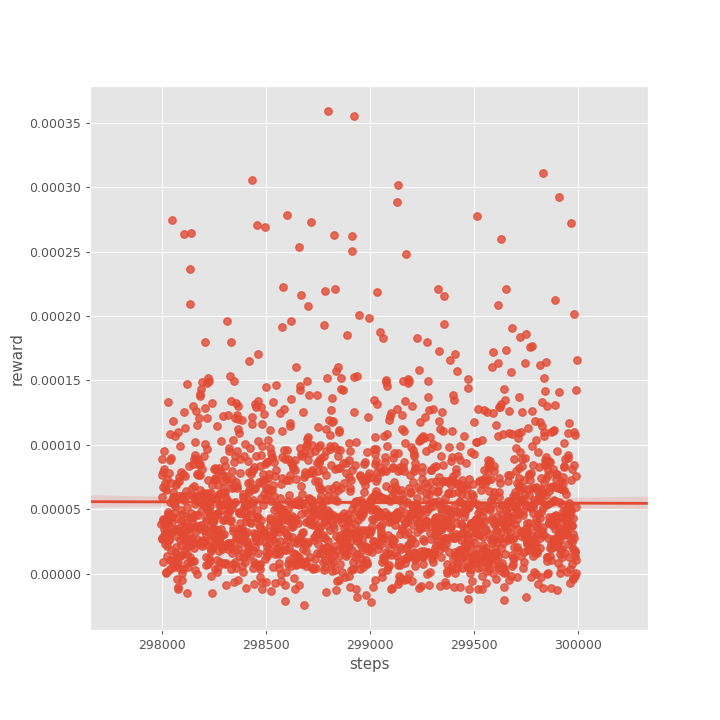

In [25]:
# View history
df = pd.DataFrame(data).T
df

df["steps"]=df.index
plt.figure(figsize=(8,8))
sns.regplot(x="steps", y="reward", data=df, order=1)

In [ ]:
# agent.save_model('./outputs/tensorforce-PPO-prioritised/tensorforcePPO')

# Test

In [63]:
df_test = pd.read_hdf('./data/poloniex_30m.hf',key='test')
env_test = PortfolioEnv(
    df=df_test,
    steps=48*7, # run for a week at a time
    scale=True, 
    trading_cost=0.0025, 
    window_length = window_length,
    output_mode='EIIE',
)
# wrap it in a few wrappers
env_test = ConcatStates(env_test)
env_test = SoftmaxActions(env_test)
environment_test = TFOpenAIGymCust('CryptoPortfolioEIIETest-v0', env_test)

env_test.seed(0)

[0]

In [64]:
# Create an agent
agent = PPOAgent(
    states_spec=environment.states,
    actions_spec=actions_spec,
    network_spec=network_spec,
    config=config
)

INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.
[2017-11-13 07:47:19,952] Create CheckpointSaverHook.


INFO:tensorflow:Restoring parameters from ./outputs/tensorforce-PPO/tensorforce_PPO_crypto_20171105_06-50-31/model.ckpt-11920000


INFO:tensorflow:Restoring parameters from ./outputs/tensorforce-PPO/tensorforce_PPO_crypto_20171105_06-50-31/model.ckpt-11920000
[2017-11-13 07:47:20,339] Restoring parameters from ./outputs/tensorforce-PPO/tensorforce_PPO_crypto_20171105_06-50-31/model.ckpt-11920000
[2017-11-13 07:47:20,648] Configuration values not accessed: local_model, summary_logdir, summary_frequency, cluster_spec, task_index, parameter_server, distributions, summary_labels, replica_model


INFO:tensorflow:Saving checkpoints for 11920000 into ./outputs/tensorforce-PPO/tensorforce_PPO_crypto_20171105_06-50-31/model.ckpt.


INFO:tensorflow:Saving checkpoints for 11920000 into ./outputs/tensorforce-PPO/tensorforce_PPO_crypto_20171105_06-50-31/model.ckpt.
[2017-11-13 07:47:20,676] Saving checkpoints for 11920000 into ./outputs/tensorforce-PPO/tensorforce_PPO_crypto_20171105_06-50-31/model.ckpt.


In [65]:
runner_test = Runner(agent=agent, environment=environment_test)

In [66]:
def episode_finished(r):
    print("Finished episode {ep} after {ts} timesteps (reward: {reward})".format(ep=r.episode, ts=r.episode_timestep,
                                                                                 reward=r.episode_rewards[-1]))
    return True

In [67]:
episodes=1
steps=environment_test.gym.env.env.src.steps*episodes
runner_test.run(
    episodes=episodes,
    timesteps=steps,
    deterministic=True,
    episode_finished=episode_finished,
)

Finished episode 297995 after 336 timesteps (reward: -1.1915208412851097e-07)


TypeError: Fetch argument None has invalid type <class 'NoneType'>

[2017-11-13 07:47:33,383] The liveplot callback only work when matplotlib is using the nbAgg backend. Execute 'matplotlib.use('nbAgg', force=True)'' or '%matplotlib notebook'
[2017-11-13 07:47:33,571] The liveplot callback only work when matplotlib is using the nbAgg backend. Execute 'matplotlib.use('nbAgg', force=True)'' or '%matplotlib notebook'
[2017-11-13 07:47:33,767] The liveplot callback only work when matplotlib is using the nbAgg backend. Execute 'matplotlib.use('nbAgg', force=True)'' or '%matplotlib notebook'


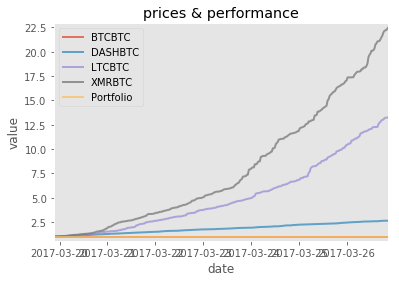

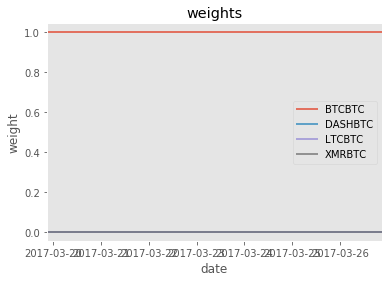

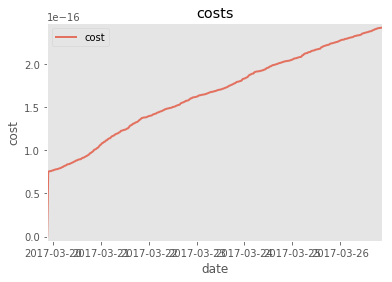

In [68]:
%matplotlib inline
environment_test.gym.render('notebook', close=True)
environment_test.gym.render('notebook')